## **Importing libraries and datasets**

In [205]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [206]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [207]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [208]:
df_transactions

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78
...,...,...,...
124995,CS8433,2011-06-26,64
124996,CS7232,2014-08-19,38
124997,CS8731,2014-11-28,42
124998,CS8133,2013-12-14,13


In [209]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [210]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [211]:
mask = (df_transactions['trans_date'] > '2014-12-17')
df_transaction_3 = df_transactions.loc[mask]
df_transaction_3

,customer_id,trans_date,tran_amount,recent
1,CS4768,2015-03-15,39,2.0
7,CS5902,2015-01-30,89,46.0
14,CS5552,2014-12-29,78,78.0
30,CS2859,2015-02-27,77,18.0
31,CS1512,2015-02-21,71,24.0
...,...,...,...,...
124874,CS8715,2015-03-15,30,2.0
124918,CS8336,2015-02-22,48,23.0
124919,CS7442,2015-03-08,25,9.0
124936,CS8207,2015-02-22,55,23.0


In [212]:
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [213]:
print(df_transaction_3['trans_date'].min())
print(df_transaction_3['trans_date'].max())

2014-12-18 00:00:00
2015-03-16 00:00:00


In [214]:
## create data set with RFM variables_3 month

df_rfm_3M = df_transaction_3.groupby('customer_id').agg({
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),
                                                     'trans_date': lambda x: (x.max() - x.min()).days})               # Monetary Value

df_rfm_3M.rename(columns={
                       'customer_id': 'frequency_3M', 
                       'tran_amount': 'monetary_value_3M',
                       'trans_date' : 'AOU_3M'}, inplace=True)

In [215]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),
                                                     'trans_date': lambda x: (x.max() - x.min()).days})               # Monetary Value           
                                               

df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

In [217]:
df_rfm.fillna(0)
df_rfm_3M.fillna(0)
df_rfm.head()

,recency,frequency,monetary_value,AOU
customer_id,,,,
CS1112,62.0,15,1012,1309
CS1113,36.0,20,1490,1354
CS1114,33.0,19,1432,1309
CS1115,12.0,22,1659,1303
CS1116,204.0,13,857,1155


In [218]:
df_rfm_3M.head()

,frequency_3M,monetary_value_3M,AOU_3M
customer_id,,,
CS1112,1,39,0
CS1113,3,220,26
CS1114,2,174,43
CS1115,1,55,0
CS1118,1,60,0


In [221]:
df_rfm_final = pd.merge(df_rfm, df_rfm_3M,how='outer', left_on='customer_id', right_on='customer_id')

In [222]:
df_rfm_final['ticket_size'] = df_rfm_final['monetary_value'] / df_rfm_final['frequency']
df_rfm_final['ticket_size_3M'] = df_rfm_final['monetary_value_3M'] / df_rfm_final['frequency_3M']

In [223]:
df_rfm_final = df_rfm_final.reset_index()
df_rfm_final.head()
df_rfm = df_rfm_final

In [225]:
df_rfm = df_rfm.fillna(0)
df_rfm.head()

,customer_id,recency,frequency,monetary_value,AOU,frequency_3M,monetary_value_3M,AOU_3M,ticket_size,ticket_size_3M
0,CS1112,62.0,15,1012,1309,1.0,39.0,0.0,67.466667,39.000000
1,CS1113,36.0,20,1490,1354,3.0,220.0,26.0,74.500000,73.333333
2,CS1114,33.0,19,1432,1309,2.0,174.0,43.0,75.368421,87.000000
3,CS1115,12.0,22,1659,1303,1.0,55.0,0.0,75.409091,55.000000
4,CS1116,204.0,13,857,1155,0.0,0.0,0.0,65.923077,0.000000


In [226]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value          
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU


df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']
df_clv.head()

,recency,frequency,monetary_value,AOU,ticket_size
customer_id,,,,,
CS1112,62.0,15,1012,1309,67.466667
CS1113,36.0,20,1490,1354,74.500000
CS1114,33.0,19,1432,1309,75.368421
CS1115,12.0,22,1659,1303,75.409091
CS1116,204.0,13,857,1155,65.923077


In [227]:
## create data set with RFM variables_3 month

df_clv_3M = df_transaction_3.groupby('customer_id').agg({
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),
                                                     'trans_date': lambda x: (x.max() - x.min()).days})               # Monetary Value

df_clv_3M.rename(columns={
                       'customer_id': 'frequency_3M', 
                       'tran_amount': 'monetary_value_3M',
                       'trans_date' : 'AOU_3M'}, inplace=True)

df_clv_3M['ticket_size_3M'] = df_clv_3M['monetary_value_3M'] / df_clv_3M['frequency_3M']

In [228]:
df_clv_3M

,frequency_3M,monetary_value_3M,AOU_3M,ticket_size_3M
customer_id,,,,
CS1112,1,39,0,39.000000
CS1113,3,220,26,73.333333
CS1114,2,174,43,87.000000
CS1115,1,55,0,55.000000
CS1118,1,60,0,60.000000
...,...,...,...,...
CS8991,2,93,14,46.500000
CS8993,1,18,0,18.000000
CS8995,1,38,0,38.000000


In [229]:
df_clv_final = pd.merge(df_clv, df_clv_3M,how='outer', left_on='customer_id', right_on='customer_id')
df_clv = df_clv_final.reset_index()
df_clv

,customer_id,recency,frequency,monetary_value,AOU,ticket_size,frequency_3M,monetary_value_3M,AOU_3M,ticket_size_3M
0,CS1112,62.0,15,1012,1309,67.466667,1.0,39.0,0.0,39.000000
1,CS1113,36.0,20,1490,1354,74.500000,3.0,220.0,26.0,73.333333
2,CS1114,33.0,19,1432,1309,75.368421,2.0,174.0,43.0,87.000000
3,CS1115,12.0,22,1659,1303,75.409091,1.0,55.0,0.0,55.000000
4,CS1116,204.0,13,857,1155,65.923077,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6884,CS8996,98.0,13,582,1120,44.769231,NaN,NaN,NaN,NaN
6885,CS8997,262.0,14,543,1116,38.785714,NaN,NaN,NaN,NaN
6886,CS8998,85.0,13,624,1293,48.000000,1.0,49.0,0.0,49.000000
6887,CS8999,258.0,12,383,1073,31.916667,NaN,NaN,NaN,NaN


In [230]:
df_clv = df_clv.fillna(0)
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size,frequency_3M,monetary_value_3M,AOU_3M,ticket_size_3M
0,CS1112,62.0,15,1012,1309,67.466667,1.0,39.0,0.0,39.000000
1,CS1113,36.0,20,1490,1354,74.500000,3.0,220.0,26.0,73.333333
2,CS1114,33.0,19,1432,1309,75.368421,2.0,174.0,43.0,87.000000
3,CS1115,12.0,22,1659,1303,75.409091,1.0,55.0,0.0,55.000000
4,CS1116,204.0,13,857,1155,65.923077,0.0,0.0,0.0,0.000000


## **Calculating response rate**

In [231]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


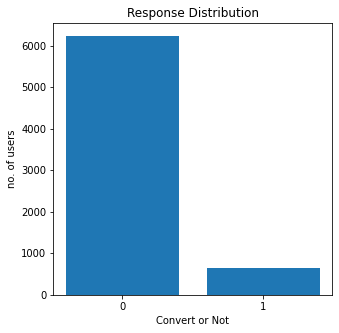

In [232]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [233]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_clv)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size,frequency_3M,monetary_value_3M,AOU_3M,ticket_size_3M
0,CS1112,0,62.0,15,1012,1309,67.466667,1.0,39.0,0.0,39.000000
1,CS1113,0,36.0,20,1490,1354,74.500000,3.0,220.0,26.0,73.333333
2,CS1114,1,33.0,19,1432,1309,75.368421,2.0,174.0,43.0,87.000000
3,CS1115,1,12.0,22,1659,1303,75.409091,1.0,55.0,0.0,55.000000
4,CS1116,1,204.0,13,857,1155,65.923077,0.0,0.0,0.0,0.000000


In [234]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size,frequency_3M,monetary_value_3M,AOU_3M,ticket_size_3M
0,CS1112,0,62.0,15,1012,1309,67.466667,1.0,39.0,0.0,39.000000
1,CS1113,0,36.0,20,1490,1354,74.500000,3.0,220.0,26.0,73.333333
2,CS1114,1,33.0,19,1432,1309,75.368421,2.0,174.0,43.0,87.000000
3,CS1115,1,12.0,22,1659,1303,75.409091,1.0,55.0,0.0,55.000000
4,CS1116,1,204.0,13,857,1155,65.923077,0.0,0.0,0.0,0.000000


## **Creating train and test dataset**

In [237]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [238]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

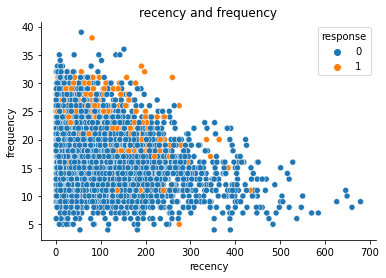

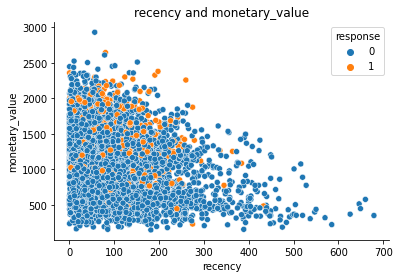

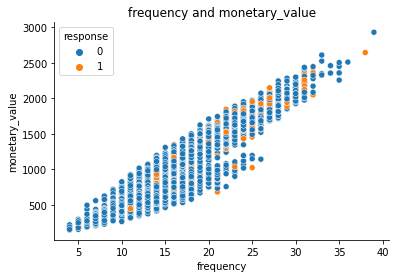

In [239]:
# Not used
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

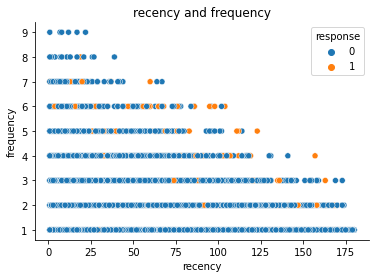

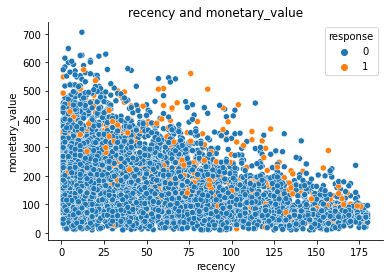

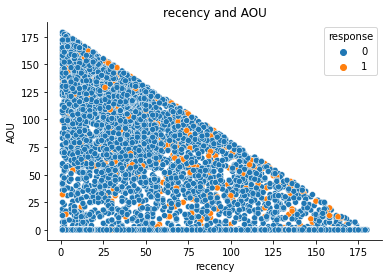

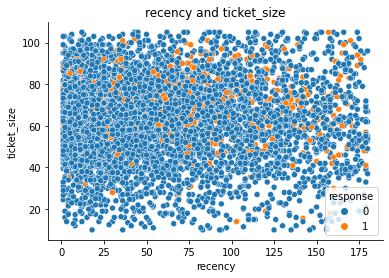

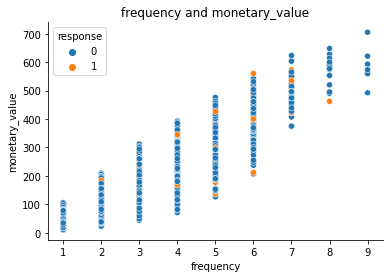

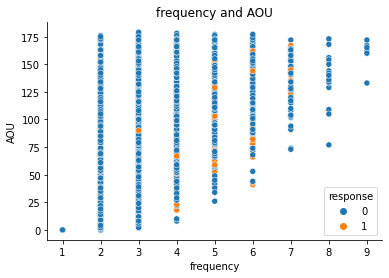

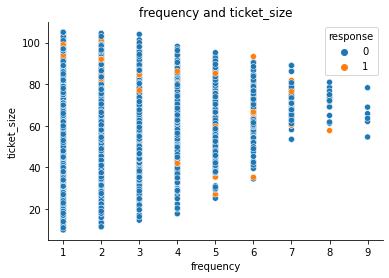

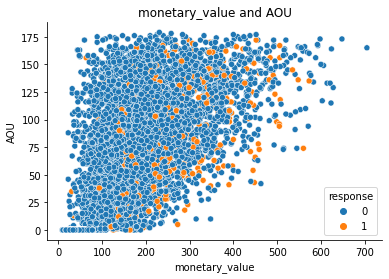

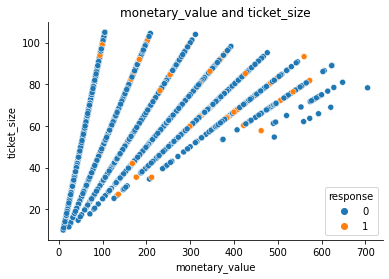

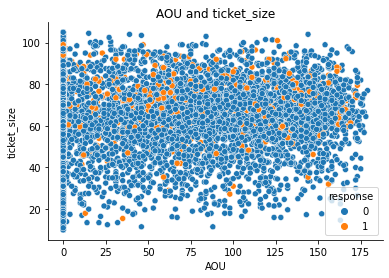

In [71]:
# Not used
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [240]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_sample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_sample(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression**

In [241]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4389
           1       0.65      0.71      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      1848
           1       0.18      0.72      0.29       218

    accuracy                           0.63      2066
   macro avg       0.57      0.67      0.52      2066
weighted avg       0.87      0.63      0.70      2066



In [242]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4389
           1       0.65      0.71      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      1848
           1       0.18      0.72      0.29       218

    accuracy                           0.63      2066
   macro avg       0.57      0.67      0.52      2066
weighted avg       0.87      0.63      0.70      2066



## **XGBoost**

In [243]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.706164
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.706164
[2]	validation_0-auc:0.706164
[3]	validation_0-auc:0.706164
[4]	validation_0-auc:0.706164
[5]	validation_0-auc:0.714522
[6]	validation_0-auc:0.717757
[7]	validation_0-auc:0.718448
[8]	validation_0-auc:0.717791
[9]	validation_0-auc:0.717006
[10]	validation_0-auc:0.717478
[11]	validation_0-auc:0.718319
[12]	validation_0-auc:0.718225
Stopping. Best iteration:
[7]	validation_0-auc:0.718448

training set
              precision    recall  f1-score   support

           0       0.75      0.60      0.67      4389
           1       0.67      0.80      0.73      4389

    accuracy                           0.70      8778
   macro avg       0.71      0.70      0.70      8778
weighted avg       0.71      0.70      0.70      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.61      0.75      1848
   

In [244]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.706164
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.706164
[2]	validation_0-auc:0.706164
[3]	validation_0-auc:0.706164
[4]	validation_0-auc:0.706164
[5]	validation_0-auc:0.714522
[6]	validation_0-auc:0.717757
[7]	validation_0-auc:0.718448
[8]	validation_0-auc:0.717791
[9]	validation_0-auc:0.717006
[10]	validation_0-auc:0.717478
[11]	validation_0-auc:0.718319
[12]	validation_0-auc:0.718225
Stopping. Best iteration:
[7]	validation_0-auc:0.718448

training set
              precision    recall  f1-score   support

           0       0.75      0.60      0.67      4389
           1       0.67      0.80      0.73      4389

    accuracy                           0.70      8778
   macro avg       0.71      0.70      0.70      8778
weighted avg       0.71      0.70      0.70      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.61      0.75      1848
   

In [245]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [246]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.7min finished


In [247]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.707339800688367
[[1180  668]
 [  66  152]]
test set
              precision    recall  f1-score   support

           0       0.95      0.64      0.76      1848
           1       0.19      0.70      0.29       218

    accuracy                           0.64      2066
   macro avg       0.57      0.67      0.53      2066
weighted avg       0.87      0.64      0.71      2066



In [248]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 300, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7fbf43ddec20>}
